Установка библиотеки numba

In [1]:
!pip install numba

In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

GPU-реализация вычисления числа pi

In [3]:
@cuda.jit
def gpu_pi_calculating(pi, coef, states):
	tidx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
	x = xoroshiro128p_uniform_float32(states, tidx)
	y = xoroshiro128p_uniform_float32(states, tidx)
	if x*x + y*y < 1:
		cuda.atomic.add(pi, 0, coef)

CPU-реализация вычисления числа pi

In [4]:
def cpu_pi_calculating(size):
  result = 0
  coef = 4/size
  pnts = np.random.rand(size, 2)
  for x, y in pnts:
    result += coef if (x*x + y*y) < 1 else 0
  return result

Сравнение подходов

In [5]:
sizes = np.array([1024, 5120, 10240, 51200, 102400, 512000, 1024000])
iterations = 10               # Количество итераций без "холодного старта"
_iterations = iterations + 1  # Количество итераций с "холодным стартом"
BLOCK_SIZE = 1024                # Размерность одного блока

"""
Словарь значений для сравнения подходов,
где среднее отклонение является средним модулем разности между истинным
значением pi и подсчитанным.
"""
values = {"Размерности":sizes,
          "CPU:Среднее время":np.zeros(len(sizes)),
          "GPU:Среднее время":np.zeros(len(sizes)),
          "CPU:Среднее отклонение":np.zeros(len(sizes)),
          "GPU:Среднее отклонение":np.zeros(len(sizes)),
          "CPU:Последнее значение pi":np.zeros(len(sizes)),
          "GPU:Последнее значение pi":np.zeros(len(sizes))}

for i_size in range(len(sizes)):

  coef = np.float32(4/sizes[i_size])

  grid_dim = int((sizes[i_size] + BLOCK_SIZE - 1) / BLOCK_SIZE)

  # Массивы с временами на соответствующем устройстве для вычисления среднего
  iter_values = {"CPU:Время":np.zeros(_iterations),
                 "GPU:Время":np.zeros(_iterations),
                 "CPU:Отклонение":np.zeros(_iterations),
                 "GPU:Отклонение":np.zeros(_iterations)}

  for iter in range(_iterations):
    gpu_pi = np.zeros(1, dtype=np.float32)
    cpu_pi = 0

    # Вычисление времени на GPU (с учётом пересылки данных)
    start_time = time()
    # Создание генератора случайных чисел
    states = create_xoroshiro128p_states(n=grid_dim * BLOCK_SIZE, seed=123)
    # Запуск GPU-реализации
    gpu_pi_calculating[grid_dim, BLOCK_SIZE](gpu_pi, coef, states)
    end_time = time()
    iter_values["GPU:Время"][iter] = end_time - start_time
    iter_values["GPU:Отклонение"][iter] = np.abs(np.pi - gpu_pi[0])

    # Суммирование с помощью стандартного sum
    start_time = time()
    cpu_pi = cpu_pi_calculating(sizes[i_size])
    end_time = time()
    iter_values["CPU:Время"][iter] = end_time - start_time
    iter_values["CPU:Отклонение"][iter] = np.abs(np.pi - cpu_pi)


  # Вычисление среднего значения времени без "холодного старта"
  values["GPU:Среднее время"][i_size] = np.mean(iter_values["GPU:Время"][1:])
  values["CPU:Среднее время"][i_size] = np.mean(iter_values["CPU:Время"][1:])
  values["CPU:Среднее отклонение"][i_size] = np.mean(iter_values["CPU:Отклонение"])
  values["GPU:Среднее отклонение"][i_size] = np.mean(iter_values["GPU:Отклонение"])
  values["CPU:Последнее значение pi"][i_size] = cpu_pi
  values["GPU:Последнее значение pi"][i_size] = gpu_pi[0]

# Сравнение результатов
results = pd.DataFrame(values)
results

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due 

,Размерности,CPU:Среднее время,GPU:Среднее время,CPU:Среднее отклонение,GPU:Среднее отклонение,CPU:Последнее значение pi,GPU:Последнее значение pi
0,1024,0.008483,0.006361,0.050338,0.028311,3.148438,3.113281
1,5120,0.034167,0.010171,0.019836,0.027412,3.117969,3.114181
2,10240,0.087663,0.018893,0.009500,0.035917,3.117578,3.105675
3,51200,0.207815,0.037412,0.004761,0.007138,3.143359,3.134455
4,102400,0.163347,0.029827,0.003613,0.004474,3.136953,3.137118
5,512000,0.782121,0.139327,0.001603,0.013734,3.144945,3.155327
6,1024000,1.282631,0.234657,0.001129,0.017745,3.142109,3.123848


Сравнение скоростей подходов

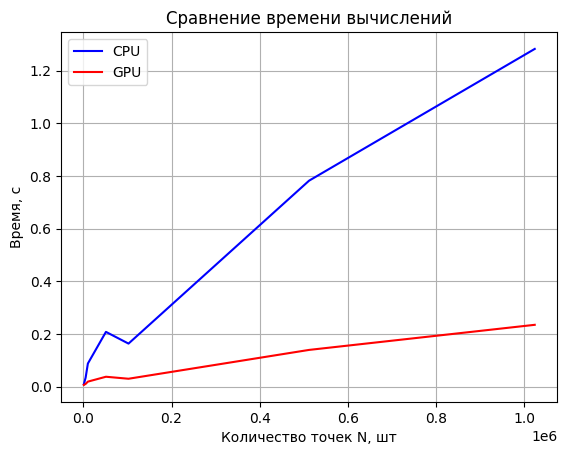

In [6]:
plt.plot(sizes, results["CPU:Среднее время"], color="blue", label="CPU")
plt.plot(sizes, results["GPU:Среднее время"], color="red", label="GPU")
plt.title("Сравнение времени вычислений")
plt.xlabel("Количество точек N, шт")
plt.ylabel("Время, с")
plt.grid()
plt.legend()

Визуализация ускорения

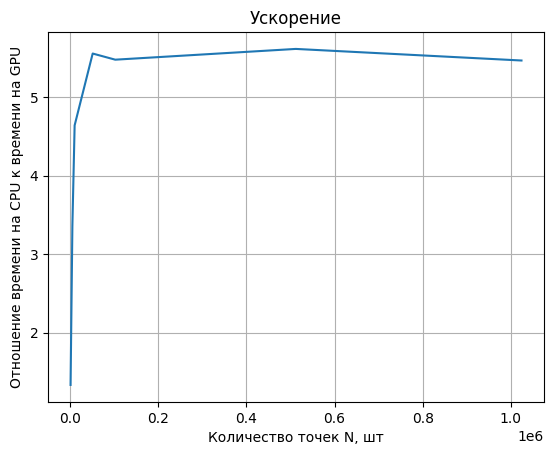

In [7]:
plt.plot(sizes, results["CPU:Среднее время"] / results["GPU:Среднее время"])
plt.title("Ускорение")
plt.xlabel("Количество точек N, шт")
plt.ylabel("Отношение времени на CPU к времени на GPU")
plt.grid()

Сохранение результатов в excel

In [8]:
results.to_excel("CPU and GPU.xlsx")